# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# import libraries here; add more as necessary 
import DataScienceHelperLibrary as dsh # my helper library https://github.com/bwenner/DataScienceHelperLibrary

import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from importlib import reload

from IPython.display import HTML
from IPython.display import display, clear_output

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from workspace_utils import active_session

# magic word for producing visualizations in notebook
%matplotlib inline

### Load dada and quick check

In [4]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

from sqlalchemy import create_engine

engine = create_engine('sqlite:///{}'.format('CustomerData.db'))

azdias = pd.read_sql_table('azdias', engine)

del engine
gc.collect()

4487

In [5]:
print(azdias.shape)
dsh.TailHead(azdias, 5)

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
891216,825761,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,15.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,NaN,NaN,NaN,NaN,17.0,3.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,NaN,NaN,NaN,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1
891220,825787,-1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,10.0,...,3.0,8.0,10.0,7.0,6.0,3.0,4.0,3,1,4


### Create config class and load info files

I did following pre configurations based on file review.

In [322]:
class CleanConfig:
    
    def IsNone(inp):
        return dsh.IsNullOrEmpty(inp)
    
    # The objects are set/filled in the same order they are listed up 
    
    LowestIdentify = []
    
    UnknownIdentify = []
    
    
    ColumnValues = {}
    
    DropColumns = []  
    
    DropD19 = True
    DropMisingKBA13 = True
    DropRowsKBA05 = True
    
    
    DropUndocumentedColumns = True
    
    ConvertToFloat = []
    
    ColumnsToLogScale = []
    
    ColumnsToOneHotEnc = []
    
    
    NumericalColumns = []

    FillMeanManually = []

    RemoveRowsByValuesInColumns = {}

    RowsToTropByMisNan = 0.35
    
    ColumnsWithoutInfo = []
    
    AttributesNotInAzdias = []
    
    AttributeLevelsNotInAzdias  = []
    
    D19Columns = []
    D19Unique  = []
    
    ColumnsReorderValues = []
    
    ColumnsSummarize = {}
    
    Imputer = preprocessing.Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
    Scaler = preprocessing.StandardScaler()
    PCA = None
    KMeans = None
    
    
    

class ColumnValues:
    def __init__(self, columnName):
        self.ColumnName = columnName
        self.UnknownValues = []
        self.KnownValues = []
        self.AllValues = []
        self.MissingDesc = []
        self.Meanings = []
        self.LowestValue = 0
        self.DType = None
        self.Description = ''
        self.Group = ''
        self.SingleValues = {}
        self.NotConvertable = []
        
    def Add(self, isunknown, value):
        if isunknown:
            self.UnknownValues.append(value)
        else:
            self.KnownValues.append(value)
        self.AllValues.append(value)

    def IsNumeric(self):
        return self.DType in dsh.NumberTypes

In [182]:
def ReadAttributeFiles():
    xlAttributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    xlInfos = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
    return xlAttributes, xlInfos

In [183]:
att, inf = ReadAttributeFiles()

In [184]:
att.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,1h,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [185]:
inf.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


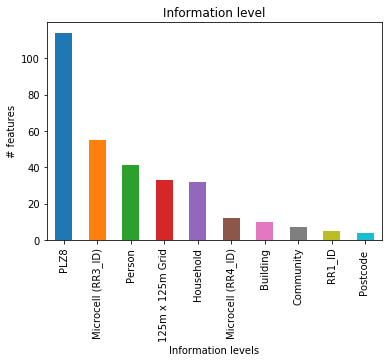

In [186]:
lastlevel = ''
for ind, row in inf.iterrows():
    if type(row['Information level']) == str and len(row['Information level']) > 0:
        lastlevel = row['Information level']
        continue
    if type(row['Information level']) != str and np.isnan(row['Information level']):
        inf.loc[ind, 'Information level'] = lastlevel
        
inf.loc[0, 'Information level'] = inf.loc[1, 'Information level'] = lastlevel

ax = inf['Information level'].value_counts().plot(kind = 'bar')
ax.set_title('Information level')
ax.set_ylabel('# features')
_ = ax.set_xlabel('Information levels')

In [328]:
CleanConfig.ColumnValues = {}

In [329]:
# After reviewing the files:

CleanConfig.LowestIdentify = [
        'no *', 'none*', '*low*', '*poorer*', '*urban*', '*demanding*', '*lowest*', '*marginal*', 
        '*minimal*', '*>*24*month*', '*than*24*month*' '*unlikely*', '*demoted*', '*poor*'
]

CleanConfig.UnknownIdentify = [
        '*unknown*', 
        '*no*classification*possible*', 
        '*classification*not*possible*', 
        'no*score*' 
]

def LoadColumnsAndValuesInfos(df):
    '''
    Load excel files and initialize CleanConfig
    '''
    xlAttributes, xlInfos = ReadAttributeFiles()
    currentAttrib = ''
    count = 0
    colVal = None

    # iterate over all rows
    
    meaning = ''
    for ind, row in xlAttributes.iterrows():
        
        # remember the current row
        if row['Attribute'] is not np.nan:

            if colVal is not None:
                if not colVal.IsNumeric():
                    colVal.MissingDesc = set(df[colVal.ColumnName].unique()) - set(colVal.AllValues)
                CleanConfig.ColumnValues[colVal.ColumnName] = colVal
            
            currentAttrib = row['Attribute'].replace('CAMEO_DEUINTL_2015', 'CAMEO_INTL_2015') 
            currentAttrib = currentAttrib.replace('SOHO_FLAG', 'SOHO_KZ')
            
            if currentAttrib not in df.columns:
                CleanConfig.AttributesNotInAzdias.append(currentAttrib)
                colVal = None
                continue
                
            colVal = ColumnValues(currentAttrib)
            colVal.DType = df[currentAttrib].dtype
        
        # When row is not contained in azdias
        if colVal is None:
            continue
        
        # handle descriptions for merged cells
        if str(row['Meaning']) != 'nan':
            meaning = str(row['Meaning'])
        
        colVal.Meanings.append(meaning.split('\n')[0])
        isunknown = any(dsh.IsMatch(meaning, x) for x in CleanConfig.UnknownIdentify)
        currentVal = row['Value']
        
        
        # if value is a number, then add and continue
        # else try to split and parse to float
        # else add the original string value.
        try:
            if type(currentVal) in dsh.NumberTypes:

                colVal.Add(isunknown, str(currentVal))
                colVal.Add(isunknown, currentVal)
                flt = float(currentVal)
                colVal.Add(isunknown, str(flt))
                colVal.SingleValues[flt] = meaning

                if any(dsh.IsMatch(meaning, x) for x in CleanConfig.LowestIdentify):
                            if colVal.LowestValue < flt:
                                colVal.LowestValue = flt

                continue

            # skip numerical columns
            if '...' in currentVal:
                # current column is numerical
                CleanConfig.NumericalColumns.append(col)
                continue

            if ',' in currentVal:
                splt = currentVal.split(',')
                for val in splt:
                    try:
                        colVal.Add(isunknown, val.strip())
                        flt = float(val.strip())
                        colVal.Add(isunknown, flt)
                        colVal.SingleValues[flt] = sv

                        if any(dsh.IsMatch(meaning, x) for x in CleanConfig.LowestIdentify):
                            if colVal.LowestValue < flt:
                                colVal.LowestValue = flt
                    except:
                        colVal.Add(isunknown, val)
                        colVal.SingleValues[val] = meaning
        except:
            print('Error while processing row {} with value "{}"'.format(ind, currentVal))          
    
    grp = ''
    desc = ''
    for ind, row in xlInfos.iterrows():
        
        col = row['Attribute']
        if len(col) == 0:
                continue
                
        desc = desc if str(row['Description']) == 'nan' else row['Description']
        grp = grp if str(row['Information level']) == 'nan' else row['Information level']

        col = col.strip()
        col = col.replace('_ ', '_').replace('_RZ', '')
        
        while ('  ' in col):
            col = col.replace('  ', ' ')
        
        for colsplt in col.split(' '):
            if len(colsplt) == 0:
                continue
                
            if colsplt in list(CleanConfig.ColumnValues.keys()):
                CleanConfig.ColumnValues[colsplt].Description = desc
                CleanConfig.ColumnValues[colsplt].Group = grp
                continue

            if colsplt not in df.columns:
                CleanConfig.AttributeLevelsNotInAzdias.append(colsplt)
                continue

            cv = ColumnValues(colsplt)
            cv.DType = df[colsplt].dtype
            cv.Description = desc
            cv.Group = grp

            CleanConfig.ColumnValues[colsplt] = cv
        
    for col in df.columns:
        if not col in CleanConfig.ColumnValues.keys():
            colVal = ColumnValues(col)
            colVal.DType = df[col].dtype
            colVal.AllValues = list(df[col].unique())
            CleanConfig.ColumnsWithoutInfo.append(col)
            CleanConfig.ColumnValues[colVal.ColumnName] = colVal  
        if df[col].dtype == object:
            cnt = 0
            for val in azdias[col].unique():
                try:
                    _ = float(val)
                except: 
                    cnt = cnt + 1
                    CleanConfig.ColumnValues[col].NotConvertable.append(val)
                if cnt > 20:
                    break    
        else: 
            if len(df[col].value_counts()) > 100 or df[col].max() > 100 or df[col].mean() > 1000:
                CleanConfig.NumericalColumns.append(col)
        
        if len(CleanConfig.ColumnValues[col].NotConvertable) > 0:
            dsh.PrintLine()
            print('Cannot convert values in {}: '.format(col), CleanConfig.ColumnValues[col].NotConvertable)
        
    
    for cv in CleanConfig.ColumnValues.values():
        if 'number of' in cv.Description and len(cv.Meanings) <= 1 and not cv.ColumnName in CleanConfig.NumericalColumns:
            print('Possible numerical feature added: ', cv.ColumnName)
            CleanConfig.NumericalColumns.append(cv.ColumnName)
    
    print('Columns and attributes successfully loaded')
    
#     for ind, x in enumerate(CleanConfig.ColumnValues['WOHNLAGE'].Meanings):
#         if dsh.IsMatch(x, '*poor*'):
#             CleanConfig.ColumnValues['WOHNLAGE'].LowestValue = ind + 1
#             break
    
LoadColumnsAndValuesInfos(azdias)

-------------------- - --------------------
Cannot convert values in CAMEO_DEU_2015:  [None, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B']
-------------------- - --------------------
Cannot convert values in CAMEO_DEUG_2015:  [None, 'X']
-------------------- - --------------------
Cannot convert values in CAMEO_INTL_2015:  [None, 'XX']
-------------------- - --------------------
Cannot convert values in D19_LETZTER_KAUF_BRANCHE:  [None, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK', 'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD', 'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST', 'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT', 'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'D19_SAMMELARTIKEL']
-------------------- - --------------------
Cannot convert values in EINGEFUEGT_AM:  [None, '1992-02-10 00:00:00', 

### Columns without value meaning & object columns

In [308]:
inspect = []
for col in azdias.columns:
    if azdias[col].dtype == object or col in CleanConfig.NumericalColumns:
        print('Skipping categorical/numerical column: ', col)
        dsh.PrintLine()
        continue
    vc = azdias[col].value_counts()
    if col in CleanConfig.ColumnsWithoutInfo or len(CleanConfig.ColumnValues[col].UnknownValues) == 0:
        print(col, sorted(azdias[col].unique()))
        inspect.append(col)
        dsh.PrintLine()
        

Skipping categorical/numerical column:  LNR
-------------------- - --------------------
AKT_DAT_KL [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
-------------------- - --------------------
ALTER_KIND1 [nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
-------------------- - --------------------
ALTER_KIND2 [nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
-------------------- - --------------------
ALTER_KIND3 [nan, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
-------------------- - --------------------
ALTER_KIND4 [nan, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
-------------------- - --------------------
ALTERSKATEGORIE_FEIN [nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0]
-------------------- - --------------------


-------------------- - --------------------
D19_VERSI_OFFLINE_DATUM [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
-------------------- - --------------------
D19_VERSI_ONLINE_DATUM [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
-------------------- - --------------------
D19_VERSI_ONLINE_QUOTE_12 [nan, 0.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
-------------------- - --------------------
D19_VERSICHERUNGEN [0, 1, 2, 3, 4, 5, 6, 7]
-------------------- - --------------------
D19_VOLLSORTIMENT [0, 1, 2, 3, 4, 5, 6, 7]
-------------------- - --------------------
D19_WEIN_FEINKOST [0, 1, 2, 3, 4, 5, 6, 7]
-------------------- - --------------------
DSL_FLAG [nan, 0.0, 1.0]
-------------------- - --------------------
Skipping categorical/numerical column:  EINGEFUEGT_AM
-------------------- - --------------------
Skipping categorical/numerical column:  EINGEZOGENAM_HH_JAHR
-------------------- - --------------------
EXTSEL992 [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.

I guess LNR stands for "laufende Nummer" ("running number") and is an index. So I drop this feature.

Looking through the data I noticed two gaps:

- ARBEIT [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 9.0]
- KOMBIALTER [1, 2, 3, 4, 9]

The first AZDIAS project provided the Data_Dictioanry.md file with information for following features so I use this information to encode them if necessary.

### 1.23. TITEL_KZ
Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other

### 9.1. ARBEIT
Share of unemployment in community
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown

There is - beside 0, -1 - another identifier for unknown values, it's the 9. So I add this information to the corresponding list. I assume that 9 is also an identifier for missing values in feature KOMBIALTER.


And now the object features:

The feature EINGEFÜEGT_AM ("inserted on") is out of interest because it gives no information about a persons interest and will be dropped without being processed.

LETZTER_KAUF_BRANCHE 

CAMEO_DEUG/INTEL_2015 can be converted to float. (CAMEO_INTL is discussed in the coming steps)

OST_WEST_KZ needs to be one hot encoded.

I'm quite unsure how to treat CAMEO_DEU_2015 because considering this feature would end in 44 new one-hot encoded features or just drop it after cleaning... I'll make this configurable.

In [309]:
for col in ['ARBEIT', 'KOMBIALTER']:
    CleanConfig.ColumnValues[col].UnknownValues.extend([9])

CleanConfig.ColumnValues['CAMEO_DEUG_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_DEUG_2015'].NotConvertable
)
CleanConfig.ColumnValues['CAMEO_INTL_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_INTL_2015'].NotConvertable
)
CleanConfig.ColumnValues['D19_LETZTER_KAUF_BRANCHE'].UnknownValues.append('D19_UNBEKANNT')

CleanConfig.DropColumns.append('EINGEFUEGT_AM')
CleanConfig.DropColumns.append('LNR')
CleanConfig.DropColumns.append('CAMEO_DEU_2015') # comment this line to take CAMEO into consideration

CleanConfig.ConvertToFloat.append('CAMEO_DEUG_2015')
CleanConfig.ConvertToFloat.append('CAMEO_INTL_2015')

### Convert missing values

With the information from the provided files, I convert the missing values to np.nan before I continue my analysis.

In [333]:
def PrepMissingValuesToNan(inpDf):
    '''
    Convert missing values to nan based on info from attribute file.
    '''
    dsh.PrintLine('Start converting missing values to nan')
    df = inpDf.copy(deep = True)
    
    for cv in CleanConfig.ColumnValues.values():
        if not cv.ColumnName in df.columns:
            continue
        if cv.ColumnName in CleanConfig.DropColumns:
            print('Skipping feature that will be droped: ', cv.ColumnName)
            continue
            
        if len(cv.UnknownValues) == 0:
            print('No unknown values given: ', cv.ColumnName)
            if cv.ColumnName in CleanConfig.ConvertToFloat:
                df[cv.ColumnName] = df[cv.ColumnName].astype(float)
                if df[cv.ColumnName].dtype in dsh.NumberTypes:
                    print('Converted to float: ', cv.ColumnName)
            continue
        
        try:
            pre = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]
            if pre == 0:
                continue

            df[cv.ColumnName] = df[cv.ColumnName].apply(
                lambda x: np.nan if (x in cv.UnknownValues or dsh.IsNull(x)) else x
            )

            aft = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]

            print(cv.ColumnName, '-', cv.UnknownValues, '-', pre, '-', aft)

            if cv.ColumnName in CleanConfig.ConvertToFloat:
                df[cv.ColumnName] = df[cv.ColumnName].astype(float)
                if df[cv.ColumnName].dtype in dsh.NumberTypes:
                    print('Converted to float: ', cv.ColumnName)

                else:
                    print('Error converting to float: ', cv.ColumnName)
            
        except:
            print('Error applying "lambda x: np.nan if x in CleanConfig.ColumnValues[col] else x')

    dsh.PrintLine('Finished converting missing values to nan')
    return df    

azRun = PrepMissingValuesToNan(azdias)

-------------------- Start converting missing values to nan --------------------
AGER_TYP - ['-1', -1, '-1.0', '0', 0, '0.0'] - 685843 - 0
ALTER_HH - ['0', 0, '0.0'] - 236768 - 0
No unknown values given:  ANZ_HAUSHALTE_AKTIV
No unknown values given:  ANZ_HH_TITEL
No unknown values given:  ANZ_PERSONEN
No unknown values given:  ANZ_TITEL
No unknown values given:  CAMEO_DEU_2015
No unknown values given:  D19_BANKEN_ANZ_12
No unknown values given:  D19_BANKEN_ANZ_24
No unknown values given:  D19_BANKEN_DATUM
No unknown values given:  D19_BANKEN_OFFLINE_DATUM
No unknown values given:  D19_BANKEN_ONLINE_DATUM
No unknown values given:  D19_BANKEN_ONLINE_QUOTE_12
No unknown values given:  D19_GESAMT_ANZ_12
No unknown values given:  D19_GESAMT_ANZ_24
No unknown values given:  D19_GESAMT_DATUM
No unknown values given:  D19_GESAMT_OFFLINE_DATUM
No unknown values given:  D19_GESAMT_ONLINE_DATUM
No unknown values given:  D19_GESAMT_ONLINE_QUOTE_12
No unknown values given:  D19_KONSUMTYP
No unknown

The analysis shows that there are columns having more than 35% missing values. This large amount of missing values is not helpful and **COULD** be removed. 

By reviewing the provided MS Excel files, I noticed that there are information that can be "summarized". I do this in the next steps. 

Now I will have quick look at the nan distribution after cleaning, then reengineer features and check again.

In [18]:
def PlotIsNullDist(df, top = 100, axis = 0, toplabels = 20, kind = 'bar'):
    '''
    Plot distribution of null values.
    
    INPUT:
    df: Dataframe
    top: when axis = 1, consider top sorted
    toplabels: print top sorted
    kind: chart
    
    OUTPUT:
    returns plotted dataframe
    '''
    
    dfPlt = None

    if axis == 0:
        dfPlt = df.isnull().sum(axis = axis).sort_values(ascending = False)[:top]
        dfPlt = dfPlt.apply(lambda x: (x * 100) / df.shape[0])
        ax = dfPlt.plot(kind = kind)
        ax.set_title('Missing values in feature')
        print(dfPlt[:toplabels])
    else:
        vc = df.isnull().sum(axis = axis).value_counts()
        dfPlt = pd.DataFrame(data=vc.values, index = vc.index)
        toplabels = dfPlt.shape[1]
        ax = dfPlt.plot(kind = kind)
        _ = ax.set_title('Value count overview')
        _ = ax.set_ylabel('Number of rows...')
        _ = ax.set_xlabel('... having # nan values')
        print(dfPlt)
    _ = ax.set_xticklabels([])
    
    
    return dfPlt

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
dtype: float64


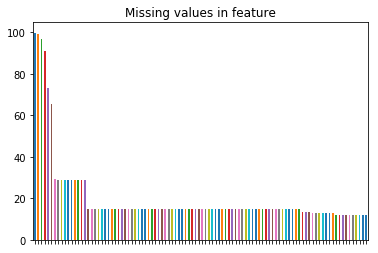

In [19]:
_ = PlotIsNullDist(azdias)

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
AGER_TYP                       76.955435
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
KBA05_BAUMAX                   53.468668
D19_LETZTER_KAUF_BRANCHE       50.767543
ALTER_HH                       34.813699
ALTERSKATEGORIE_FEIN           29.504130
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_LOTTO                      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
dtype: float64


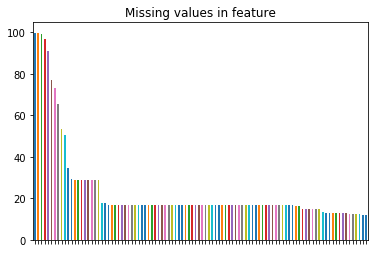

In [20]:
_ = PlotIsNullDist(azRun)

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
AGER_TYP                       76.955435
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
KBA05_BAUMAX                   53.468668
D19_LETZTER_KAUF_BRANCHE       50.767543
ALTER_HH                       34.813699
ALTERSKATEGORIE_FEIN           29.504130
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_LOTTO                      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
dtype: float64


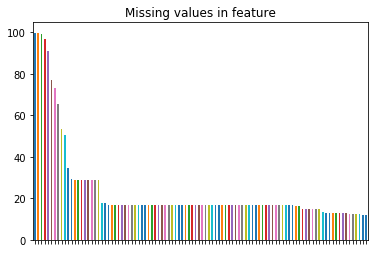

In [21]:
_ = PlotIsNullDist(azRun)

          0
5    190567
6    161599
4    119198
16    85645
15    66641
7     51469
253   45578
252   27921
3     19718
8     12873
2      6988
17     5056
225    5015
9      4945
69     4589
18     4533
226    4393
14     4306
72     3892
70     3707
71     3171
224    2837
68     2646
236    2604
73     2387
79     2345
12     2036
11     1997
235    1775
80     1773
..      ...
45        3
110       3
162       3
118       3
148       3
150       3
217       2
41        2
219       2
44        2
153       2
213       2
157       2
183       2
152       2
111       1
256       1
42        1
43        1
108       1
181       1
216       1
113       1
243       1
241       1
161       1
160       1
154       1
149       1
242       1

[204 rows x 1 columns]


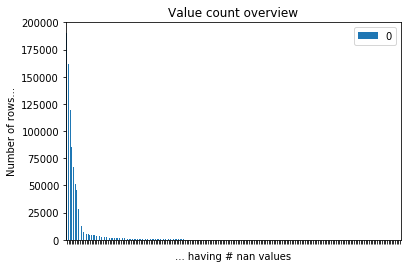

In [22]:
_ = PlotIsNullDist(azdias, axis = 1)

          0
7    114744
8    111151
9     84759
6     80296
10    56105
260   45582
19    41470
11    37140
5     35306
20    34037
17    28289
259   27923
18    26630
12    21775
16    11093
13     7670
21     6082
26     5305
22     4983
14     4950
4      4869
74     4333
27     4226
73     3844
15     3661
71     3424
72     3363
75     3254
25     2988
228    2945
..      ...
157       4
110       4
166       3
255       3
113       3
156       3
155       3
263       3
184       2
256       2
162       2
264       2
183       2
181       2
180       2
60        2
182       2
253       1
257       1
111       1
114       1
254       1
120       1
116       1
158       1
159       1
160       1
59        1
164       1
58        1

[233 rows x 1 columns]


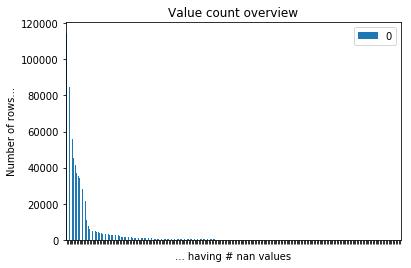

In [23]:
_ = PlotIsNullDist(azRun, axis = 1)

So 114800 rows only have 7 mising values and so on...

### Object columns & categorical features

In [285]:
azdias[[x for x in azdias.columns 
        if azdias[x].dtype == object 
        and x not in CleanConfig.DropColumns
]].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,None,None,None,None
1,8.0,51.0,None,W
2,4.0,24.0,D19_UNBEKANNT,W
3,2.0,12.0,D19_UNBEKANNT,W
4,6.0,43.0,D19_SCHUHE,W


In [286]:
azRun[[x for x in azdias.columns 
        if azRun[x].dtype == object 
        and x not in CleanConfig.DropColumns
]].head()

,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,NaN,None
1,NaN,W
2,NaN,W
3,NaN,W
4,D19_SCHUHE,W


In [30]:
print(CleanConfig.ColumnValues['CAMEO_DEUG_2015'].Meanings)
dsh.PrintLine()
print(CleanConfig.ColumnValues['CAMEO_INTL_2015'].Meanings)
dsh.PrintLine()
print(CleanConfig.ColumnValues['PRAEGENDE_JUGENDJAHRE'].Meanings)

['unknown', 'upper class', 'upper middleclass', 'established middleclasse', 'consumption-oriented middleclass ', 'active middleclass ', 'low-consumption middleclass', 'lower middleclass', 'working class', 'urban working class']
-------------------- - --------------------
['unknown', 'Wealthy Households-Pre-Family Couples & Singles', 'Wealthy Households-Young Couples With Children', 'Wealthy Households-Families With School Age Children', 'Wealthy Households-Older Families &  Mature Couples', 'Wealthy Households-Elders In Retirement', 'Prosperous Households-Pre-Family Couples & Singles', 'Prosperous Households-Young Couples With Children', 'Prosperous Households-Families With School Age Children', 'Prosperous Households-Older Families & Mature Couples', 'Prosperous Households-Elders In Retirement', 'Comfortable Households-Pre-Family Couples & Singles', 'Comfortable Households-Young Couples With Children', 'Comfortable Households-Families With School Age Children', 'Comfortable Households

CAMEO_DEUG_2015 has been treated in the previous steps (converted to float and reordered values).

OST_WEST_KZ will be one-hot encoded (replace W, E by 1, 0). For the other columns I create new features and extract the relevant information (except the D19 shown above because I will have a closer look to it later).

The other columns have been converted to float and will be treted in the next steps.

In [ ]:
def PrepObjectColumns(dfInput):
    df = dfInput.copy(deep = True)
    dsh.PrintLine('Preparing column: OST_WEST_KZ')
    
    df['OST_WEST_KZ'] = dsh.ApplyBinaryEncoding(df['OST_WEST_KZ'])
    
    dsh.PrintLine('Preparing column: CAMEO_INTL_2015')
    print(df['CAMEO_INTL_2015'].value_counts())
    df['CAMEO_INTL_2015_Wealth'] = pd.to_numeric(df['CAMEO_INTL_2015']) // 10
    df['CAMEO_INTL_2015_Ages'] = pd.to_numeric(df['CAMEO_INTL_2015']) % 10
    print(df['CAMEO_INTL_2015_Ages'].value_counts())
    print(df['CAMEO_INTL_2015_Wealth'].value_counts())
    df = df.drop('CAMEO_INTL_2015', axis = 1)
    
    dsh.PrintLine('Preparing column: PRAEGENDE_JUGENDJAHRE')
    print(df['PRAEGENDE_JUGENDJAHRE'].value_counts())
    mainstreamId = []
    ages = {}
    praegO = []
    praegW = []
    
    col = 'PRAEGENDE_JUGENDJAHRE'
    for ind, x in enumerate(CleanConfig.ColumnValues[col].Meanings):
        if ind == 0:
            continue
        if 'Mainstream' in x:
            mainstreamId.append(ind)
        elif 'Avant' in x:
            avantId.append(ind)
        else:
            print('Neither "Mainstream" nor "Avant" in value: ', x)
        
        if dsh.IsMatch(x, ['*O)', '* O+*']):
            praegO.append(ind)
        elif dsh.IsMatch(x, ['*W)', '* W+*']):
            praegW.append(ind)

        ages[ind] = float(x[:2]) / 10.0

    df['PRAEGENDE_JUGENDJAHRE_MainAvant'] = df[col].apply(
        lambda x: 1 if x in mainstreamId
                else 0 if x in avantId
                else x
    )
    
    df['PRAEGENDE_JUGENDJAHRE_Ages'] = df[col].apply(
        lambda x: x if np.isnan(x) else ages[x]
    )
    
    df['PRAEGENDE_JUGENDJAHRE_Ost'] = df[col].apply(
        lambda x: x if np.isnan(x) else 1 if x in praegO else 0
    )
    df['PRAEGENDE_JUGENDJAHRE_West'] = df[col].apply(
    lambda x: x if np.isnan(x) else 1 if x in praegW else 0
    )
    
    print(df['PRAEGENDE_JUGENDJAHRE_Ost'].value_counts())
    print(df['PRAEGENDE_JUGENDJAHRE_West'].value_counts())
    dsh.PrintLine(ages)
    
    print(df['PRAEGENDE_JUGENDJAHRE_MainAvant'].value_counts())
    print(df['PRAEGENDE_JUGENDJAHRE_Ages'].value_counts())
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
        
    if 'CAMEO_DEU_2015' in df.columns and not 'CAMEO_DEU_2015' in CleanConfig.DropColumns:
        print('Pay attention: CAMEO_DEU_2015 one-hot encoding')
        df = dsh.ApplyOneHotEncoding(df, columns=['CAMEO_DEU_2015'])
    
    
    
    
    
    
    dsh.PrintLine(n=10)
    print('New columns: ', set(df.columns) - set(dfInput.columns))
    dsh.PrintLine(n=10)
    print('Dropped columns: ', set(dfInput.columns) - set(df.columns))
    dsh.PrintLine('Finished object column preparation')
    
    return df

azRun = PrepObjectColumns(azRun)

### Reorder and shift values
There are some columns whose values to not correspond for what they actually stand for (for example (0 - verly likely, 10 very unlikely). I intend to run PCA on the data and for easier interpretation I change the order of these values.

In [341]:
CleanConfig.ColumnsReorderValues = []
for cv in CleanConfig.ColumnValues.values():
    if cv.ColumnName in CleanConfig.DropColumns:
        continue
    if cv.LowestValue > 2:
        print(cv.ColumnName, cv.LowestValue)
        CleanConfig.ColumnsReorderValues.append(cv.ColumnName)

CAMEO_DEUG_2015 9.0
CAMEO_INTL_2015 55.0
D19_BANKEN_DATUM 10.0
D19_BANKEN_OFFLINE_DATUM 10.0
D19_BANKEN_ONLINE_DATUM 10.0
D19_GESAMT_DATUM 10.0
D19_GESAMT_OFFLINE_DATUM 10.0
D19_GESAMT_ONLINE_DATUM 10.0
D19_TELKO_DATUM 10.0
D19_TELKO_OFFLINE_DATUM 10.0
D19_TELKO_ONLINE_DATUM 10.0
D19_VERSAND_DATUM 10.0
D19_VERSAND_OFFLINE_DATUM 10.0
D19_VERSAND_ONLINE_DATUM 10.0
FINANZ_ANLEGER 5.0
FINANZ_HAUSBAUER 5.0
FINANZ_MINIMALIST 5.0
FINANZ_SPARER 5.0
FINANZ_UNAUFFAELLIGER 5.0
FINANZ_VORSORGER 5.0
GEBAEUDETYP_RASTER 4.0
HH_EINKOMMEN_SCORE 6.0
KBA05_HERSTTEMP 4.0
KBA05_MODTEMP 4.0
KKK 4.0
LP_LEBENSPHASE_FEIN 31.0
LP_LEBENSPHASE_GROB 10.0
LP_STATUS_FEIN 5.0
MOBI_REGIO 6.0
REGIOTYP 7.0
RETOURTYP_BK_S 5.0
SEMIO_DOM 7.0
SEMIO_ERL 7.0
SEMIO_FAM 7.0
SEMIO_KAEM 7.0
SEMIO_KRIT 7.0
SEMIO_KULT 7.0
SEMIO_LUST 7.0
SEMIO_MAT 7.0
SEMIO_PFLICHT 7.0
SEMIO_RAT 7.0
SEMIO_REL 7.0
SEMIO_SOZ 7.0
SEMIO_TRADV 7.0
SEMIO_VERT 7.0
SHOPPER_TYP 3.0
WOHNLAGE 5.0


FINANZTYPs highest scalar value standing for 'unremarkable' is not on top of 'investor'. So I rearange the values: 

- 0 = unremarkable,
- 1 = low fincancial interest, ...
- 6 = investor

I also shift the values in the column describing the nationality. Currently its 1=sounding german, 2 = sounding foreign, 3 = assimilated.

In [ ]:
def ReorderValues(dfInput):
    dsh.PrintLine('Start reordering values')
    df = dfInput.copy(deep = True)
    
    for col in CleanConfig.ColumnsReorderValues:
        
        if col in CleanConfig.DropColumns:
            print('Skipping column because it will be dropped: ', col)
            continue
        if not col in df.columns:
            print('Skipping column because it is not contained: ', col)
            continue
        
        vmin = df[col].min()
        vmax = df[col].max()
        
        dsh.PrintLine()
        print('current column: ', col)
        
        repDic = {}
        for ind in range (int(vmin), int(vmax) + 1):
            repDic[ind] = float(vmax + 1 - ind)
        
        dsh.PrintLine('Applying reorder on {}: {}'.format(col, repDic))
        
        meanings = CleanConfig.ColumnValues[col].Meanings
        if len(meanings) > 2:
            print('Having meanings: ', meanings[:1], ' - ', meanings[:-1])
        try:
            df[col] = df[col].apply(lambda x: repDic[x] if x in repDic.keys() else x)
        except:
            print('Error reordering values in column "{}": '.format(col), repDic, df[col].unique())
            return
    
    dsh.PrintLine('Finished reordering values')
    return df


def ShiftRight(ser, mod):
    return ser.apply(
        lambda x: 
        x if x == 0 or np.isnan(x) # don't change the meaning of unknown!
        else ((x % mod) + 1)
    )

def ShiftLeft(ser, mod):
    return ser.apply(
        lambda x: 
        x if x == 0 or np.isnan(x) # don't change the meaning of unknown!
        else (x - 2) % mod + 1
        # 1 => 3
        # 3 => 2
        # 2 => 1
    )

def ShiftValues(dfInput):
    dsh.PrintLine('Start shifting vaues')
    df = dfInput.copy(deep = True)
    
    df['FINANZTYP'] = ShiftRight(df['FINANZTYP'], 6)
    df['NATIONALITAET_KZ'] = ShiftLeft(df['NATIONALITAET_KZ'], 3)
    
    dsh.PrintLine('Finshed shifting vaues')
    return df

def PrepReorderShiftValues(dfInput):
    df = dfInput.copy(deep = True)
    df = ReorderValues(df)
    df = ShiftValues(df)
    return df

# quick check
ShiftValues(pd.DataFrame({'FINANZTYP' : [0,1,2,3,4,5,6], 'NATIONALITAET_KZ' : [0,1,2,3, 0, 1, 2]}))

In [ ]:
#azRun = Prep5_ShiftValues(Prep4_ReorderValues(Prep3_LogScale(Prep2_DropRowsAndColumns(Prep1_MissingValuesToNan(azdias)))))
azRun = PrepReorderShiftValues(azRun)

In [ ]:
pd.concat([
    azdias[azdias.index < 5][CleanConfig.ColumnsReorderValues], 
    azRun[azRun.index < 5][CleanConfig.ColumnsReorderValues]
])

### Drop rows and columns by missing values

The following functions will help me to identify and remove outliner rows and columns.

In [33]:
def CalcMeanOutlinerRows(df):
    '''
    Calc mean of missing values in each row
    '''
    return df.copy(deep = True).isnull().sum(axis = 1) / df.shape[1]

def PlotCalcMean(df):
    tmp = []
    dfsum = CalcMeanOutlinerRows(df)
    for ind in range(11):
        tmp.append(dfsum[dfsum.between(0.0, ind / 11)].shape[0] / dfsum.shape[0])

    tmp = pd.DataFrame(tmp)
    ax = tmp.plot(kind = 'bar')
    ax.set_xticks([x + 0.5 for x in range(0, 11)])
    ax.set_xlabel('% missing values')
    ax.set_ylabel('% of dataset')
    _ = ax.set_xticklabels([str(x) for x in range(0, 110, 10)])

    del tmp, ax

def SelectOutlinerRows(dfInp):
    '''
    Select rows by: dfInput[CalcMeanOutlinerRows(dfInput) > CleanConfig.RowsToTropByMisNan]
    '''
    df = dfInp.copy(deep = True)
    return df[CalcMeanOutlinerRows(df) > CleanConfig.RowsToTropByMisNan]

def DropOutlinerRows(dfInp):
    '''
    Drop rows by: dfInput[CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan]
    '''
    df = dfInp.copy(deep = True)
    return df[CalcMeanOutlinerRows(df) <= CleanConfig.RowsToTropByMisNan]

def DropDuplicates(dfInp):
    '''
    Drop duplicates
    '''
    df = dfInp.copy(deep = True)
    bef = df.shape[0]
    dftmp = df.drop_duplicates()
    dsh.PrintLine('{} duplicate rows removed'.format(bef - df.shape[0]))
    return dftmp

def PrepDropRowsAndColumnsByNAN(dfInp):
    '''
    Remove rows by: CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan 
                    ALTER_HH in [1, .., CleanConfig.RemoveRowsByAlterHHLimit]
    
    '''
    df = dfInp.copy(deep = True)
    
    df = DropOutlinerRows(df)
    
    dsh.PrintLine('{} rows removed '.format(dfInp.shape[0] - df.shape[0], CleanConfig.RowsToTropByMisNan))
    
    df = dsh.RemoveColumnsByWildcard(df, CleanConfig.DropColumns)
    
    bef = df.shape[0]
    
    df = DropDuplicates(df)
    
    return df

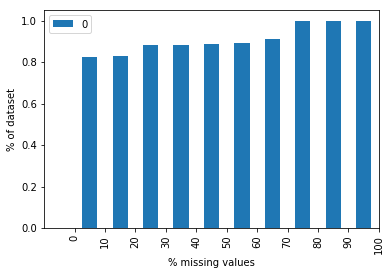

In [34]:
PlotCalcMean(azRun)

In [35]:
dsh.AnalyzeNanColumns(azRun)

-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 86, 23.37%
LNR, type: int64                           0.0
D19_BANKEN_ANZ_12, type: int64             0.0
D19_BANKEN_ANZ_24, type: int64             0.0
D19_BANKEN_DATUM, type: float64            0.0
D19_BANKEN_DIREKT, type: int64             0.0
D19_BANKEN_GROSS, type: int64              0.0
D19_BANKEN_LOKAL, type: int64              0.0
D19_BANKEN_OFFLINE_DATUM, type: float64    0.0
D19_BANKEN_ONLINE_DATUM, type: float64     0.0
D19_BANKEN_REST, type: int64               0.0
D19_BEKLEIDUNG_GEH, type: int64            0.0
D19_BEKLEIDUNG_REST, type: int64           0.0
D19_BILDUNG, type: int64                   0.0
D19_BIO_OEKO, type: int64                  0.0
D19_BUCH_CD, type: int64                   0.0
D19_DIGIT_SERV, type: int64                0.0
D19_DROGERIEARTIKEL, type: int64           0.0
D19_ENERGIE, type: int64                   0.0
D19_FREIZEIT, type: int64             

So most of of the columns have less that 35% of missing values. Outliners are those with a minimum of 50% of missing values and will be dropped.

In [336]:
CleanConfig.RowsToTropByMisNan = 0.35

### Check outliner rows and engineer GESAMT, CJT, CCM, HERST, ALTER/HALTER

In [38]:
def PlotHeatmap(df):
    return sns.heatmap(df, cmap = 'Blues')

def PlotSubSet(df1, df2, ind):
    title = 'Distribution for the feature: ' + df1.columns[ind]
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    sns.countplot(df1.iloc[:, ind].values, color = 'blue')
    plt.subplot(1, 2, 2)
    if all(np.isnan(df2.iloc[:, ind].values)):
        #sns.countplot(df2.iloc[:, ind].values, color = 'blue')
        pass
    else:
        sns.countplot(df2.iloc[:, ind].values, color = 'blue')
        
def PlotHeatmap3(df1, df2, df3):
    plt.figure(figsize = (20,15))
    plt.subplot(2, 2, 1)
    ax = PlotHeatmap(df1)
    ax.set_title('Dropped rows')
    plt.subplot(2, 2, 2)
    _ = PlotHeatmap(df2)
    ax.set_title('Considered rows')
    plt.subplot(2, 2, 3)
    _ = PlotHeatmap(df3)
    _ = ax.set_title('Currently all rows')

In [337]:
for cv in CleanConfig.ColumnValues.values():
    if 'county average' in cv.Description:
        print(cv.ColumnName, ' - ', cv.Description)
        CleanConfig.DropColumns.append(cv.ColumnName)

KBA05_KRSAQUOT  -  share of cars per household (reffered to county average)
KBA05_KRSHERST1  -  share of Mercedes/BMW (reffered to the county average)
KBA05_KRSHERST2  -  share of Volkswagen (reffered to the county average)
KBA05_KRSHERST3  -  share of Ford/Opel (reffered to the county average)
KBA05_KRSKLEIN  -  share of small cars (referred to the county average)
KBA05_KRSOBER  -  share of upper class cars (referred to the county average)
KBA05_KRSVAN  -  share of vans (referred to the county average)
KBA05_KRSZUL  -  share of newbuilt cars (referred to the county average)
KBA13_KRSAQUOT  -  share of cars per household (referred to the county average) - PLZ8
KBA13_KRSHERST_AUDI_VW  -  share of Volkswagen (referred to the county average) - PLZ8
KBA13_KRSHERST_BMW_BENZ  -  share of BMW/Mercedes Benz (referred to the county average) - PLZ8
KBA13_KRSHERST_FORD_OPEL  -  share of FORD/Opel (referred to the county average) - PLZ8
KBA13_KRSSEG_KLEIN  -  share of small cars (referred to the c

In [41]:
azRun[dsh.GetMatches(azRun.columns, ['*k*alter*', '*halter*'])].head()

,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KOMBIALTER
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,4.0,1.0,4.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,4.0,1.0
2,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0
3,2.0,5.0,3.0,0.0,2.0,3.0,5.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,5.0,5.0,4.0,3.0,2.0,4.0
4,0.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,2.0,3.0,3.0,3.0


In [58]:
dfwork = azRun[azRun['KBA13_ALTERHALTER_30'] != azRun['KBA05_ALTER1']][['KBA13_ALTERHALTER_30', 'KBA05_ALTER1', 'KBA13_HALTER_25', 'KBA13_HALTER_30']]

dfwork = dfwork[dfwork['KBA13_HALTER_30'].isnull()]

dfwork[dfwork.isnull().sum(axis = 1) < 4]

,KBA13_ALTERHALTER_30,KBA05_ALTER1,KBA13_HALTER_25,KBA13_HALTER_30
15,NaN,4.0,NaN,NaN
20,NaN,3.0,NaN,NaN
23,NaN,3.0,NaN,NaN
415,NaN,2.0,NaN,NaN
883,NaN,2.0,NaN,NaN
1008,NaN,0.0,NaN,NaN
1631,NaN,4.0,NaN,NaN
1683,NaN,0.0,NaN,NaN
1940,NaN,2.0,NaN,NaN
1981,NaN,4.0,NaN,NaN


In [70]:
matches = dsh.GetMatches(azRun.columns, ['*ccm*'])
azRun[matches].head()

,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,5.0,1.0,4.0,2.0,0.0,0.0,4.0,3.0,1.0,2.0,2.0,5.0,3.0,3.0,0.0,5.0
2,5.0,2.0,3.0,0.0,1.0,1.0,2.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0
3,2.0,3.0,5.0,1.0,3.0,4.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,5.0
4,4.0,1.0,4.0,2.0,3.0,5.0,1.0,2.0,1.0,4.0,1.0,3.0,3.0,3.0,5.0,5.0,5.0


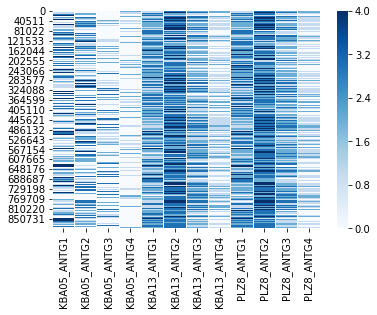

In [82]:
matches = dsh.GetMatches(azRun.columns, ['*_antg*'])
_ = PlotHeatmap(azRun[matches])

In [106]:
dsh.GetMatches(azRun.columns, 'kba05*_max*')

['KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB']

In [99]:
dfwork = azRun[dsh.GetMatches(azRun.columns, '*05*herst*')][['KBA05_MAXHERST', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5' ]]

wrongmax = []
for ind, row in dfwork.iterrows():
    if np.isnan(row['KBA05_MAXHERST']):
        continue
    hsid = str(row['KBA05_MAXHERST'])[0]
    
    hv = row['KBA05_HERST' + hsid]
    if hv < max(row['KBA05_HERST1'], row['KBA05_HERST2'], row['KBA05_HERST3'], row['KBA05_HERST4'], row['KBA05_HERST5']):
        wrongmax.append(ind)

dsh.PrintLine(len(wrongmax), 'rows where KBA05_MAXHERST is wrong')

CleanConfig.DropColumns.extend(dsh.GetMatches(azRun.columns, 'kba05*_max*'))
CleanConfig.DropColumns.append('KBA05_HERSTTEMP')
CleanConfig.DropColumns.append('KBA05_MODTEMP')

84270


In [176]:
matches = dsh.GetMatches(azRun.columns, '*d19*', '*d19*bank*')
azRun[azRun[matches].sum(axis = 1) > 200] 

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Ages,PRAEGENDE_JUGENDJAHRE_MainAvant,PRAEGENDE_JUGENDJAHRE_Ages
41,796675,NaN,1.0,20.0,NaN,NaN,NaN,NaN,20.0,1.0,...,2.0,9.0,2.0,2,2,1,3.0,1.0,1.0,1.0
45,507843,1.0,1.0,21.0,18.0,NaN,NaN,NaN,11.0,1.0,...,1.0,9.0,7.0,4,2,4,1.0,5.0,4.0,4.0
51,507869,NaN,9.0,21.0,13.0,NaN,NaN,NaN,21.0,2.0,...,1.0,6.0,7.0,1,1,1,2.0,5.0,1.0,1.0
79,710251,NaN,1.0,21.0,NaN,NaN,NaN,NaN,21.0,9.0,...,2.0,5.0,4.0,4,1,1,1.0,5.0,1.0,1.0
149,760061,NaN,1.0,20.0,NaN,NaN,NaN,NaN,15.0,1.0,...,2.0,9.0,7.0,4,2,3,3.0,2.0,3.0,3.0
180,796730,NaN,1.0,18.0,9.0,NaN,NaN,NaN,0.0,1.0,...,1.0,9.0,3.0,1,2,2,3.0,2.0,2.0,2.0
235,482781,NaN,9.0,17.0,4.0,7.0,NaN,NaN,17.0,1.0,...,1.0,9.0,7.0,2,2,2,3.0,4.0,2.0,2.0
294,939416,NaN,2.0,20.0,NaN,NaN,NaN,NaN,15.0,9.0,...,2.0,9.0,3.0,4,1,3,0.0,2.0,3.0,3.0
350,444155,NaN,7.0,20.0,NaN,NaN,NaN,NaN,20.0,13.0,...,4.0,9.0,4.0,4,1,1,0.0,4.0,1.0,1.0
372,554943,1.0,1.0,21.0,12.0,14.0,16.0,NaN,8.0,2.0,...,1.0,9.0,7.0,4,2,4,4.0,3.0,4.0,4.0


In [101]:
azRun[dsh.GetMatches(azRun.columns, '*max*')].head()

,D19_KONSUMTYP_MAX,KBA05_BAUMAX,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA13_BAUMAX,PLZ8_BAUMAX
0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,5.0,2.0,1.0,2.0,4.0,3.0,2.0,1.0
2,8,NaN,3.0,4.0,5.0,1.0,1.0,1.0,1.0
3,8,1.0,3.0,4.0,3.0,2.0,2.0,1.0,1.0
4,1,NaN,2.0,2.0,3.0,1.0,1.0,2.0,2.0


In [102]:
azRun[dsh.GetMatches(azRun.columns, '*zul*')].head()

,KBA05_KRSZUL,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_KRSZUL_NEU
0,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,5.0,1.0,0.0,2.0,1.0
2,3.0,2.0,3.0,4.0,4.0,1.0
3,3.0,3.0,3.0,3.0,3.0,2.0
4,2.0,3.0,4.0,2.0,2.0,3.0


In [112]:
dfwork = azRun[dsh.GetMatches(azRun.columns, '*titel*')]

dfwork[(dfwork['TITEL_KZ'] > 0) & (dfwork['ANZ_HH_TITEL'].isnull() )]

,ANZ_HH_TITEL,ANZ_TITEL,TITEL_KZ
6815,NaN,1.0,1.0
13132,NaN,1.0,1.0
41662,NaN,0.0,1.0
48991,NaN,0.0,1.0
91600,NaN,1.0,1.0
96600,NaN,1.0,1.0
98030,NaN,1.0,1.0
115031,NaN,1.0,1.0
133731,NaN,1.0,1.0
136141,NaN,1.0,1.0


In [116]:
azRun[(azRun['TITEL_KZ'] > 0) & (azRun['TITEL_KZ'] < 5) & (azRun['ANZ_HH_TITEL'].isnull())]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Ages,PRAEGENDE_JUGENDJAHRE_MainAvant,PRAEGENDE_JUGENDJAHRE_Ages
6815,282188,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,3,2,3,NaN,NaN,NaN,NaN
13132,565984,3.0,9.0,16.0,NaN,NaN,NaN,NaN,11.0,NaN,...,3.0,9.0,NaN,3,1,3,NaN,NaN,4.0,4.0
41662,990531,1.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,0.0,...,NaN,9.0,1.0,2,1,3,4.0,2.0,4.0,4.0
48991,245081,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,0.0,...,NaN,1.0,7.0,2,1,3,2.0,2.0,4.0,4.0
91600,656879,NaN,1.0,NaN,NaN,NaN,NaN,NaN,24.0,0.0,...,NaN,9.0,3.0,1,2,3,0.0,5.0,1.0,1.0
96600,895545,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,3,1,4,NaN,NaN,4.0,4.0
98030,589063,NaN,1.0,17.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,9.0,NaN,2,1,3,NaN,NaN,3.0,3.0
115031,332133,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,3,2,3,NaN,NaN,3.0,3.0
133731,1020817,2.0,1.0,11.0,NaN,NaN,NaN,NaN,11.0,NaN,...,NaN,9.0,NaN,3,1,4,NaN,NaN,4.0,4.0
136141,524357,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,3,2,3,NaN,NaN,NaN,NaN


In [241]:
dfwork = azRun[dsh.GetMatches(azRun.columns, '*kind*')]
dfwork[(~dfwork['W_KEIT_KIND_HH'].isnull()) & (dfwork['ALTER_KIND1'].isnull())].head()

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_KINDER,D19_KINDERARTIKEL,W_KEIT_KIND_HH
1,NaN,NaN,NaN,NaN,0.0,0,3.0
2,NaN,NaN,NaN,NaN,0.0,0,3.0
4,NaN,NaN,NaN,NaN,0.0,0,2.0
5,NaN,NaN,NaN,NaN,0.0,0,6.0
6,NaN,NaN,NaN,NaN,0.0,0,3.0


In [250]:
dfwork[(~dfwork['W_KEIT_KIND_HH'].isnull()) & (dfwork['ALTER_KIND1'].isnull()) & (dfwork['ANZ_KINDER'] > 2)].shape

(7, 7)

In [249]:
dfwork[(dfwork['W_KEIT_KIND_HH'].isnull()) & (~dfwork['ALTER_KIND1'].isnull()) & (dfwork['ANZ_KINDER'] > 2)].shape

(99, 7)

In [340]:
azRun[['KONSUMNAEHE', 'KKK', 'INNENSTADT']]

,KONSUMNAEHE,KKK,INNENSTADT
0,NaN,NaN,NaN
1,1.0,2.0,8.0
2,5.0,2.0,4.0
3,4.0,NaN,6.0
4,4.0,3.0,1.0
5,5.0,4.0,7.0
6,5.0,3.0,3.0
7,3.0,1.0,3.0
8,4.0,1.0,4.0
9,4.0,1.0,4.0


In [ ]:
def Apply_WKKind(row):
    # ALTER_KIND1	ALTER_KIND2	ALTER_KIND3	ALTER_KIND4	ANZ_KINDER	D19_KINDERARTIKEL	W_KEIT_KIND_HH
    if row['ALTER_KIND1'] > 0 or row['ALTER_KIND2'] > 0 | row['ALTER_KIND3'] > 0 or row['ALTER_KIND4'] > 0 
def PrepReengineering(dfInput):
    df = dfInput.copy(deep = True)
    dropCols = []
    
######## "summarize" ########

    dicMax = {
        'KBA13_ALTERHALTER_U30': ['KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_ALTERHALTER_30'],
        'KBA13_ALTERHALTER_3045': ['KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_ALTERHALTER_45'],
        'KBA13_ALTERHALTER_4560': ['KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_ALTERHALTER_60'],
        'KBA13_ALTERHALTER_O60': ['KBA13_HALTER_65', 'KBA13_HALTER_66',                    'KBA13_ALTERHALTER_61'],
        
        
        'KBA13_CCM_U1400': ['KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_0_1400', 'KBA13_CCM_1000'],
        'KBA13_CCM_14001800': ['KBA13_CCM_1400_2500', 'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_1500'],
        'KBA13_CCM_O1800': ['KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_1800'],
    
        
        'KBA05_KWU60': ['KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_0_60', 'KBA05_KW1', ''],
        'KBA05_KW6012': ['KBA13_KW_70', 'KBA13_KW_61_120', 'KBA13_KW_80', 'KBA13_KW_90', 'KBA13_KW_90', '', 'KBA13_KW_120', 'KBA05_KW2'],
        'KBA05_KWO120': ['KBA13_KW_121', 'KBA05_KW3'],
        
        'KBA13_BJ_O2004': ['KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BJ_2009'],
        'KBA13_BJ_U2004': ['KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2004'],
        
        
        'KBA13_KMH_U140': ['KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_0_140'],
        'KBA13_KMH_140210': ['KBA13_KW_70', 'KBA13_KW_61_120', 'KBA13_KW_80', 'KBA13_KW_90', 'KBA13_KW_90', '', 'KBA13_KW_120', 'KBA05_KW2'],
        'KBA13_KMH_O211': ['KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251'],
        
        'KBA13_VORB_12': ['KBA13_VORB_1', 'KBA13_VORB_2', 'KBA13_VORB_1_2'],
        
        'KBA13_SITZE_O5': ['KBA13_SITZE_4', 'KBA13_SITZE_5'],
        
        'PLZ8_ANTG_12': ['PLZ8_ANTG2', 'PLZ8_ANTG1'],
        'PLZ8_ANTG_34': ['PLZ8_ANTG3', 'PLZ8_ANTG4'],
        
        'KBA05_ANTG_12': ['KBA05_ANTG2', 'KBA05_ANTG1'],
        'KBA05_ANTG_34': ['KBA05_ANTG3', 'KBA05_ANTG4'],
        
        'KBA05_HERST_12': ['KBA05_HERST1', 'KBA05_HERST2'],
        'KBA05_HERST_34': ['KBA05_HERST3', 'KBA05_HERST4'],
        'KBA05_HERST_5': ['KBA05_HERST5'],
        
        'KBA05_SEG_Low' : ['KBA05_SEG1', 'KBA05_SEG2', 'KBA05_SEG2'],
        'KBA05_SEG_Mid' : ['KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG4'],
        'KBA05_SEG_Up' : ['KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG8', 'KBA05_SEG8'],
        'KBA05_SEG_Else' : ['KBA05_SEG7', 'KBA05_SEG9', 'KBA05_SEG10', 'KBA05_SEG10'],
        
        'KBA13_SEG_Low' : ['KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_KOMPAKTKLASSE'],
        'KBA13_SEG_Mid' : [
            'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_OBEREMITTELKLASSE'],
        'KBA13_SEG_Up' : ['KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SPORTWAGEN'],
        'KBA13_SEG_Else' : [
            'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_MINIVANS','KBA13_SEG_GROSSRAUMVANS', 
            'KBA13_SEG_WOHNMOBILE', 'KBA13_SEG_VAN', 'KBA13_SEG_UTILITIES'],
                
        'KBA13_GermanCars' : ['KBA13_AUDI', 'KBA13_BMW', 'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ', 
                             'KBA13_MERCEDES', 'KBA13_VW', 'KBA13_VW'],
        'KBA13_EUCars' : [ 'KBA13_FIAT', 'KBA13_FORD', 'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', 
                          'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT', 'KBA13_RENAULT'],
        'KBA13_AsianOther' : ['KBA13_FAB_ASIEN', 'KBA13_FAB_SONSTIGE', 'KBA13_HERST_ASIEN', 'KBA13_HERST_SONST',
                             'KBA13_MAZDA', 'KBA13_NISSAN', 'KBA13_TOYOTA', 'KBA13_TOYOTA'],
        
        
        'KBA05_ZUL_Under01': ['KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL2'],
        'KBA05_ZUL_EOver01': ['KBA05_ZUL3', 'KBA05_ZUL4', 'KBA05_ZUL4'],
        
        
    }
    
    
    for key, val in dic.items():
        if key in df.columns:
            continue
        
        val.append(key)
        
        # values are already ordered by meaning (0 = low else high match)
        df[key] = df[val].max(axis = 1)
        
        val.pop()
        dropCols.extend(val)

    ######## "summarize" ########


    
    
    ######## prepare title ########
    
    df['PersonIsAcademic'] = df['TITEL_KZ'].apply(x => 0 if (np.isnan(x) or x == 0)
                                                  else 1 if (x > 0 and x < 5)
                                                  else 0)
    df['HouseHoldAcademic'] = df[ (df['PersonIsAcademic'] == 1) | (df['ANZ_HH_TITEL'] > 0) ]
    df['BuildingAcademic'] = df[ (df['PersonIsAcademic'] == 1) | (df['HouseHoldAcademic'] ==1) ]
    
    dropCols.extend(dsh.GetMatches(azRun.columns, '*titel*'))
                                                  
    ######## title ########
    
    
    
    ######## children ########
    
    # ALTER_KIND1	ALTER_KIND2	ALTER_KIND3	ALTER_KIND4	ANZ_KINDER	D19_KINDERARTIKEL	W_KEIT_KIND_HH
    df['W_KEIT_KIND_HH'] = df.apply(lambda row: Apply_WKKind(row))
    
    
    ######## title ########
    
    
    
    ######## neighbourhood ########
                                                    # pay attention, values have been reordered
    df['Neighbourhood_Good'] = df['WOHNLAGE'].apply(lambda x: x if np.isnan(x)
                                                     1 if x in [5,6,7]
                                                     else 0)  
    df['Neighbourhood_Bad'] = df['WOHNLAGE'].apply(lambda x: x if np.isnan(x)
                                                     1 if x in [3, 4]
                                                     else 0)  
    df['Neighbourhood_Rural'] = df['WOHNLAGE'].apply(lambda x: x if np.isnan(x)
                                                     1 if x in [1, 2]
                                                     else 0) 
    dropCols.append('WOHNLAGE')
    
    ######## neighbourhood ########
    
    
    
    ######## retour type ########
    
    df['RETOURTYP_HeavyReturner'] = df['RETOURTYP_BK_S'].apply(lambda x: x if np.isnan(x)
                                                              else x in [1, 2])
    
    dropCols.append('RETOURTYP_BK_S')
    
    ######## retour type ########
    
    
    
    ######## risky ########
    
    df['GEOSCORE_NoRisk'] = df['GEOSCORE_KLS7'].apply(lambda x: x if np.isnan(x)
                                                              else x in [1, 2])
    df['GEOSCORE_MidRisk'] = df['GEOSCORE_KLS7'].apply(lambda x: x if np.isnan(x)
                                                              else x in [3, 4, 5])
    df['GEOSCORE_HighRisk'] = df['GEOSCORE_KLS7'].apply(lambda x: x if np.isnan(x)
                                                              else x > 5)
    
    dropCols.append('RETOURTYP_BK_S')
    
    ######## risky ########
    
    
    
    ######## motor type ########
    
    df['KBA13_MOTOR_HighEngine'] = df['KBA13_MOTOR'].apply(lambda x: x if np.isnan(x)
                                                              else 1 if x in [3,4]
                                                              else 0)
    df['KBA13_MOTORLowEngine'] = df['KBA13_MOTOR'].apply(lambda x: x if np.isnan(x)
                                                              else 1 if x in [1, 2]
                                                              else 0)
    dropCols.append('KBA13_MOTOR')
    
    
    df['KBA05_MOTOR_SmallEngine'] = df['KBA05_MOTOR'].apply(lambda x: x if np.isnan(x)
                                                              else x in [1, 2]
                                                           )
    df['KBA05_MOTOR_LowEngine'] = df['KBA13_MOTOR'].apply(lambda x: x if np.isnan(x)
                                                              else x in [3, 4]
                                                           )
    dropCols.append('KBA05_MOTOR')
    
    ######## motor type ########
    
    
    
    ######## unemployment ########

    df['RELAT_AB_High'] = df['RELAT_AB'].apply(lambda x: x if np.isnan(x)
                                          else 1 if x in [4, 5]
                                          else 0)
    df['RELAT_AB_Mid'] = df['RELAT_AB'].apply(lambda x: x if np.isnan(x)
                                          else 1 if x in [2, 3, 4]
                                          else 0)
    df['RELAT_AB_Low'] = df['RELAT_AB'].apply(lambda x: x if np.isnan(x)
                                          else 1 if x in [1, 2, 3]
                                          else 0)
    
    dropCols.append('RELAT_AB')
    
    ######## unemployment ########
    

    

        
        
        
    
    
    df = dsh.RemoveColumnsByWildcard(df, dropcols)    
    
    return df

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*gesamt*')].head()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*cjt_*')].describe()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*d19*o*ine*')].describe()

In [ ]:
PlotHeatmap(azRun[dsh.GetMatches(azRun.columns, '*d19*o*ine*')])

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*herst*')].head()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*herst*')].describe()

In [ ]:
PlotHeatmap(azRun[dsh.GetMatches(azRun.columns, '*herst*')])

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*halter*')].head()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*halter*')].describe()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*_bj_*')].describe()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*_bj_*')].head()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*ccm*')].head()

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*ccm*')].describe()

    df['PersonIsAcademic'] = df['TITEL_KZ'].apply(x => 0 if (np.isnan(x) or x == 0)
                                                  else 1 if (x > 0 and x < 5)
                                                  else 0)
    df['HouseHoldAcademic'] = df[ (df['PersonIsAcademic'] == 1) | (df['ANZ_HH_TITEL'] > 0) ]
    df['BuildingAcademic'] 
I create new features PersonIsAcademic, HouseHoldAcademic, BuildingAcademic based on the provided information.

KBA05_MAXHERST represents max(KBA05_HERST1, .., KBA05_HERST5) but has circa 87000 wrong entries as I discovered with my counter check. This information is not needed an can be dropped. Dito for columns matching to wildcard kba05*_max. KBA05_HERSTTEMP, KBA05_MODTEMP describe the most common car manufacturer and segment in neighborhood. So they will also be excluded.

I drop the features with the description 'refered to country average' because this information is out of interest.

The features KBA13_ALTERHALTER_.., KBA05_ALTER.. and KBA13_HALTER_.. describe share of car owners. This is a little redundant and will be cleaned. First I create a temp series in which I store the max of ALTERHALTER and ALTER and take ALTERHALTER into consideration for the relevant ages.

The same for all features having 'ccm' in name. I merge the information into KBA05_CCM1, KBA05_CCM23 (new feature created containing the max of CCM2 and CCM3 because KBA13_CCM_1400_2500 does not provide any information for < 1800ccm and > 1800ccm).

KBA13_BJ_1999 - 2008 describe different amount of years, so I reencode them to < 2004 and >= 2004.


In [37]:
for dropCol in list(dsh.GetColumnHavingNanPercent(
    azRun, percent = CleanConfig.RowsToTropByMisNan).columns):
    print('Adding feature: ', dropCol)
    CleanConfig.DropColumns.append(dropCol)

Adding feature:  AGER_TYP
Adding feature:  ALTER_KIND1
Adding feature:  ALTER_KIND2
Adding feature:  ALTER_KIND3
Adding feature:  ALTER_KIND4
Adding feature:  D19_LETZTER_KAUF_BRANCHE
Adding feature:  EXTSEL992
Adding feature:  KBA05_BAUMAX
Adding feature:  KK_KUNDENTYP
Adding feature:  TITEL_KZ


In [ ]:
azdiasConsid = DropDuplicates(DropOutlinerRows(azRun))

azdiasOut = SelectOutlinerRows(azRun)

azdias.shape, azdiasOut.shape, azdiasConsid.shape

In [ ]:
subsetD19 = dsh.GetMatches(azRun.columns, '*d19*')

subsetKBA05 = dsh.GetMatches(azRun.columns, '*kba05*')

subsetKBA13 = dsh.GetMatches(azRun.columns, '*kba13*')

subsetAllOther = set(azRun.columns) - set(subsetD19) - set(subsetKBA05) - set(CleanConfig.NumericalColumns)
subsetAllOther = subsetAllOther - set(subsetKBA13) - set(CleanConfig.DropColumns)
subsetAllOther = list(subsetAllOther)

In [ ]:
PlotHeatmap3(
    azdiasOut[subsetD19].isnull(),
    azdiasConsid[subsetD19].isnull(),
    azRun[subsetD19].isnull()
)

In [ ]:
PlotHeatmap3(
    azdiasOut[subsetKBA05].isnull(),
    azdiasConsid[subsetKBA05].isnull(),
    azRun[subsetKBA05].isnull()
)

In [ ]:
PlotHeatmap3(
    azdiasOut[subsetKBA13].isnull(),
    azdiasConsid[subsetKBA13].isnull(),
    azRun[subsetKBA13].isnull()
)

In [ ]:
PlotHeatmap3(
    azdiasOut[subsetAllOther].isnull(),
    azdiasConsid[subsetAllOther].isnull(),
    azRun[subsetAllOther].isnull()
)

In [ ]:
inspecColumns = ['FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'HH_EINKOMMEN_SCORE', 'KONSUMNAEHE', 'KBA13_ANZAHL_PKW', 'KKK']

pltConsid = azdiasConsid[inspecColumns]
pltOut = azdiasOut[inspecColumns]
    
PlotSubSet(pltConsid, pltOut, 0)

In [ ]:
PlotSubSet(pltConsid, pltOut, 1)

In [ ]:
PlotSubSet(pltConsid, pltOut, 2)

In [ ]:
PlotSubSet(pltConsid, pltOut, 3)

In [ ]:
PlotSubSet(pltConsid, pltOut, 4)

In [ ]:
PlotSubSet(pltConsid, pltOut, 5)

In [ ]:
del azdiasConsid, azdiasOut

I decided to compare the columns because they are widelsy spread with the prob of missing values. Furthermore, I guess these columns are relevant. For example Finanz_Sparer says if a person is a money saver or not, HH_Einkomen_Sore and KBA13_Anzahl_PKW the netto income per household, distance from points of sale (personally I would take people - who live far away - more into consideration) and their mobility, and finally KKK the purchasing power in the relevant region.

The plots for...:

Finanz_Sparer and HH_EINKOMMEN_SCOREcompletely differ,
KONSUMNAEHE are almost equal for value 1, 2, 3, 4, 6, 7, value 5 is in subplot 1 higher,
KBA13_ANZAHL_PKW are also different,
and KKK are for value 3 and 4 is almost equal. Subset2 has more infos with value 2, subset1 has less infos with value 1,
I added the feature Finanz_Unauffaelliger because I was irritated because of the equality of some plots. And this output is completely different. I guess the plot for columns with high range of missing values is likely to be equal.

In [ ]:
azRun = PrepDropRowsAndColumnsByNAN(azRun)

In [ ]:

dfwork = azRun[subsetD19].isnull().sum()
print(dfwork[dfwork > 0])

if CleanConfig.DropD19:
    dropcols = [col for col in dfwork[dfwork > 0].index]
    dsh.PrintLine('Adding to drop columns:' + str(dropcols))
    CleanConfig.DropColumns.extend(dropcols)

In [ ]:
dfwork = azRun[subsetKBA05].isnull().sum(axis = 1)
vc = dfwork.value_counts()
print(vc)

if CleanConfig.DropRowsKBA05:
    lim = min([x for x in vc.index if x > 10])
    rb = azRun.shape[0]
    azRun = azRun[dfwork < lim]
    print('Rows removed by "DropRowsKBA05": ', rb - azRun.shape[0])   

In [ ]:
dfwork = azRun[azRun['KBA13_SITZE_4'].isnull()]
dfwork = dfwork.isnull().sum(axis = 1)
dfwork.value_counts()

In [ ]:
if CleanConfig.DropMisingKBA13:
    rb = azRun.shape[0]
    azRun = azRun[~azRun.index.isin(dfwork.index)]
    print('Rows removed by "DropMisingKBA13": ', rb - azRun.shape[0])

In [ ]:
azRun = azRun[[col for col in azRun.columns if not col in CleanConfig.DropColumns]]

### Numerical columns

In [ ]:
lst = list(set(CleanConfig.NumericalColumns) - set(CleanConfig.DropColumns))
dfwork = azdias[lst]
dfwork.head()

In [ ]:
azdias[CleanConfig.NumericalColumns].describe()

In [ ]:
sum(azdias['GEBURTSJAHR'] == 0)

A possible birth year of 0 is senseless. Adding 0 to the unknown values, then the column would be dropped later because of the previous determined limit of keeping columns having less or equal 35% missing values. 

In [ ]:
vc = azdias['ANZ_HAUSHALTE_AKTIV'].value_counts()
#vc[vc < 350000].plot(kind = 'bar')
# vc.plot(kind = 'bar')
vc

In [ ]:
CleanConfig.FillMeanManually = ['GEBURTSJAHR']
def PrepFillManuallyWithMean(dfinp, col):
    df = dfinp.copy(deep = True)
    for col in CleanConfig.FillMeanManually:
        mn = dfinp[col].mean()
        df[col] = df[col].apply(lambda x: mn if np.isnan(x) else x)

In [ ]:
aztest = azRun.copy(deep = True)

tmpmean = aztest[aztest['GEBURTSJAHR'] > 0].mean()
aztest['GEBURTSJAHR'] = aztest['GEBURTSJAHR'].apply(lambda x: np.nan if x is 0 else x)
print(tmpmean)
PlotIsNullDist(aztest)

del aztest, tmpmean

In [ ]:
ax = dfwork.isnull().sum().plot(kind = 'bar')
ax.set_title('Missing values in numerical feature')
ax.set_xlabel('Features')
_ = ax.set_ylabel('# missing values')

There are quite a few missing values but they will be later replaced by mean. But I will drop the column EINGEZOGEN_AM because I don't think that it is relevant to consider when a person moved in.

In [ ]:
dfwork = azdias[inspect].isnull().sum()
ax = dfwork.plot(kind = 'bar')
ax.set_title('Missing values in feature\nwithout value description')
ax.set_xlabel('Feature')
ax.set_ylabel('# missing values')
_ = ax.set_xticklabels([])

I definitely remove these outliner features.

In [ ]:
ax = dfwork[dfwork > 400000].plot(kind = 'bar')
ax.set_title('Feature with > 35% missing values')
ax.set_ylabel('# missing values')
_ = ax.set_xlabel('Feature')

In [ ]:
CleanConfig.DropColumns.append('EINGEZOGENAM_HH_JAHR')
if 'EINGEZOGENAM_HH_JAHR' in azRun.columns:
    azRun = azRun[[x for x in azRun.columns if x != 'EINGEZOGENAM_HH_JAHR']]
    
newdropcols = []
for col in dfwork[dfwork > 400000].index:
    CleanConfig.DropColumns.append(col)
    newdropcols.append(col)
print('Feature will be dropped: {}'.format(newdropcols))
del newdropcols

azRun = azRun[[x for x in azRun.columns if not x in CleanConfig.DropColumns]]

### Log scale

In [ ]:
azRunSafe = azRun.copy(deep = True)

In [ ]:
# check if to logscale
checkcols = []
for col in azdias.columns:
    if not col in CleanConfig.NumericalColumns or col in CleanConfig.DropColumns:
        continue
    if azdias[col].max() > 60:
        val = azdias[col].max() / azdias[col].mean()
        checkcols.append(col)
        if (val > 5) or val < 1:
            print('Added for log scaling: ', col, ', ', val)
            CleanConfig.ColumnsToLogScale.append(col)
        else:
            print('Some big values in columns... skipping column: ', col, ', ', val)
            continue

In [ ]:
def PrepLogScale(dfinp):
    df= dfinp.copy(deep = True)
    
    for col in df.columns:
        if not col in CleanConfig.ColumnsToLogScale:
            continue
            
        df[col] = df[col].apply(lambda x: np.nan if dsh.IsNull(x) else np.log(x + 1))
        print('Log scaling applied on: ', col)
    
    return df

In [ ]:
azRun = PrepLogScale(azRun)

### Now I investigate same subsets with given values.

In [ ]:
plt.figure(figsize = (20,15))
_ = sns.heatmap(azRun[subsetD19], cmap='Blues')

In [ ]:
for col in subsetD19:
    maxi = azRun[col].value_counts().max() / azRun[col].shape[0]
    if maxi > 0.9:
        print(col, maxi)

In [ ]:
highvaluecount = []
for col in azRun.columns:
    lim = azRun[col].value_counts().max() / azRun.shape[0]
    if lim > .9:
        print(lim, col)
        highvaluecount.append(col)

In [ ]:
plt.figure(figsize = (20,15))
_ = sns.heatmap(azRun[[x for x in highvaluecount if x[:3] =='D19']], cmap = 'Blues')

In [ ]:
plt.figure(figsize = (20,15))
_ = sns.heatmap(azRun[subsetKBA05], cmap='Blues')

In [ ]:
plt.figure(figsize = (20,15))
_ = sns.heatmap(azRun[subsetKBA13], cmap='Blues')

In [ ]:
for col in subsetD19:
    prob = azRun[col].value_counts().max() / azRun.shape[0]
    if prob > 0.9:
        print(col, prob)

### 0.6 Further reduction

In [ ]:
azdias[['KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_0_1400']][10:20]

I will drop following colums because they are described by KBA13_CCM_0_1400, 1400_2500, 2501.

In [ ]:
CleanConfig.DropColumns.extend([
    'KBA13_CCM_1000',
    'KBA13_CCM_1200',
    'KBA13_CCM_1400',
    'KBA13_CCM_1500',
    'KBA13_CCM_1600',
    'KBA13_CCM_1800',
    'KBA13_CCM_2000',
    'KBA13_CCM_2500'])

In [ ]:
azdias[['KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004']][10:20]

In [ ]:
cv = CleanConfig.ColumnValues['KBA13_BJ_1999']

cv.LowestValue

BJ_2004 means share of card built BEFORE 2004, BJ_1999, 2000 stands for cars built betwen 1995-1999, 2000-2003.
I drop BJ_1999, 2000 and summarize the values of columns BJ_2006-2009 in a new column called KBA13_BJ_2004_O.

In [ ]:
CleanConfig.DropColumns.append('KBA13_BJ_1999')
CleanConfig.DropColumns.append('KBA13_BJ_2000')

And the same for KBA13_ALTERHALTER and KBA13_Halter. KBA13_HALTER is described by KBA13_ALTERHALTER.

In [ ]:
CleanConfig.DropColumns.extend(dsh.GetMatches(azdias.columns, '*_halter_*'))

Dito for KMH_110, 140, 180, 250 and KW_30, 40, ..., 

In [ ]:
CleanConfig.DropColumns.extend([
    'KBA13_KMH_110',
    'KBA13_KMH_140',
    'KBA13_KMH_180',
    'KBA13_KMH_250',
    'KBA13_KMH_251',

    'KBA13_KW_30',
    'KBA13_KW_40',
    'KBA13_KW_50',
    'KBA13_KW_60',
    'KBA13_KW_70',
    'KBA13_KW_80',
    'KBA13_KW_90',
    'KBA13_KW_110',
    'KBA13_KW_120',

])


In [ ]:
dfwork = dsh.WCS(azRun, 'd19*').head()

print([x for x in azRun['D19_LETZTER_KAUF_BRANCHE'].unique() if not x in azRun.columns])
dfwork

In [ ]:
dftmp = dsh.SelectColumnsByWildcard(azdias, 'cjt*')
dftmp.head()

In [ ]:
dfCjt = pd.DataFrame({'Mean_0' : dftmp[dftmp['CJT_GESAMTTYP'] == 0.0].mean()})

for ind in range(1, 7):
    colname = 'Mean_' + str(ind)
    dfCjt = dfCjt.join(pd.DataFrame({colname : dftmp[dftmp['CJT_GESAMTTYP'] == ind].mean()}))

dfCjt

I assume that CTJ_GESAMT is an AZ DIAS internal rating for the columns CTJ_Katalog, -Type_1-6. So I decide to consider the calculated vaöie CKTGESAMTTYP and drop the other CJT* columns.

In [ ]:
for colname in dfCjt.index:
    if colname == 'CJT_GESAMTTYP':
        CleanConfig.ColumnsToOneHotEnc.append(colname)
        continue
        
    CleanConfig.DropColumns.append(colname)

In [ ]:
def Prep6_LastReduction(dfInp):
    df = dfInp.copy(deep = True)
    
    if CleanConfig.DropUndocumentedColumns:
        print('Drop undocumented columns')
        df = dsh.RemoveColumnsByWildcard(df, CleanConfig.ColumnsWithoutInfo)
    
    df = dsh.RemoveColumnsByWildcard(df, CleanConfig.DropColumns)
    
    return df

In [ ]:
azRun = Prep6_LastReduction(azRun)

### 0.7 One hot encoding, feature extract

Many colums are like (0,1,2,3) = low, (4,5) = middle, (6,7) = high or (0,1,2,3) = low, (4,5,6) = high.

I use my previous preparation (reordering, shifting) to represent multiple columns by one.

In [ ]:
notknown = [(col, azdias[col].max()) for col in azdias.columns 
     if not azdias[col].dtype == object 
     and col not in CleanConfig.ColumnsToOneHotEnc
     and azdias[col].max() > 10
     and col not in CleanConfig.NumericalColumns
     and col not in CleanConfig.DropColumns
]

In [ ]:
azRun[[x[0] for x in notknown ]].describe()

In [ ]:
dsh.AnalyzeValueCounts(azRun, [x[0] for x in notknown ])

In [ ]:
CleanConfig.ColumnValues['PRAEGENDE_JUGENDJAHRE'].Meanings

In [ ]:
def Prep7_OneHot(dfinp):
    df = dfinp.copy(deep = True)
    
    dsh.PrintLine('Start preparing one-hot encoding')
    for col in df.columns:
        #try:
            
        if col in CleanConfig.ColumnsToLogScale or col in CleanConfig.NumericalColumns:
            continue

        if col in CleanConfig.DropColumns:
            continue
        
        ohFlag = False
        ohNewCols = []
        
        if df[col].dtype == object:
                if col in CleanConfig.ColumnsBinaryEncode:
                    df[col] = dsh.ApplyBinaryEncoding(serinp = df[col])
                    df[col] = df[col].astype(float) # to be sure...

                elif col == 'CAMEO_DEU_2015':
                    ohFlag = True
                elif col in CleanConfig.ColumnsToOneHotEnc:
                    ohFlag = True
                else:
                    dsh.PrintLine('Unprocessable column: ' + str(col))
                    dsh.PrintLine('Dropping column: ' + str(col))
                    CleanConfig.DropColumns.append(col)

        
        elif col in CleanConfig.ColumnsToOneHotEnc:
            ohFlag = True


        elif col == 'PRAEGENDE_JUGENDJAHRE':
            mainstreamId = []
            ages = {}
            avantId = []
            
            for ind, x in enumerate(CleanConfig.ColumnValues[col].Meanings):
                if ind == 0:
                    continue
                if 'Mainstream' in x:
                    mainstreamId.append(ind)
                else:
                    avantId.append(ind)

                ages[ind] = float(x[:2]) / 10.0

            df['PRAEGENDE_JUGENDJAHRE_MainAvant'] = df[col].apply(
                lambda x: 1 if x in mainstreamId
                        else 0 if x in avantId
                        else x
            )

            df['PRAEGENDE_JUGENDJAHRE_Ages'] = df[col].apply(
                lambda x: ages[x] if x in ages.keys() else x
            )

            df = df.drop(col, axis = 1)
            continue


        elif col == 'CAMEO_INTL_2015':
            df['CAMEO_INTL_2015_Wealth'] = df[col].apply(
                lambda x: x if np.isnan(x) else int(x / 10)
            )

            df['CAMEO_INTL_2015_Ages'] = df[col].apply(
                lambda x: x if np.isnan(x) else (x - 10*int(x/10))
            )

            df = df.drop(col, axis = 1)

            
        elif col == 'LP_LEBENSPHASE_FEIN':
            df['LP_LEBENSPHASE_FEIN_High_Income'] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if not x in CleanConfig.ColumnValues[col].SingleValues.keys()
                          else 1 if dsh.IsMatch(CleanConfig.ColumnValues[col].SingleValues[x], '*high*income*')
                          else 0
            )

            df['LP_LEBENSPHASE_FEIN_High_Age'] = df[col].apply(
                lambda x: x if np.isnan(x)
                            else 0 if not x in CleanConfig.ColumnValues[col].SingleValues.keys()
                            else 1 if dsh.IsMatch(CleanConfig.ColumnValues[col].SingleValues[x], '*high*age*')
                            else 0
            )

            df = dsh.RemoveColumnsByWildcard(df, col)


        elif col == 'KBA05_MOTOR':
            ohFlag = True
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if x == 1
                          else 2 if x == 4
                          else 1
            )


        elif col == 'KBA13_MOTOR':
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if x < 3
                          else 1
            )

            
        elif col == 'GEBAEUDETYP':
            df['GEBAEUDETYP_Business'] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 1 if x in [3, 4, 5, 6, 7, 8]
                          else 0
            )
            df['GEBAEUDETYP_Empty'] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 1 if x in [2, 5, 6, 8]
                          else 0
            )

            df = dsh.RemoveColumnsByWildcard(df, col)


        elif col == 'LP_LEBENSPHASE_GROB':
            df['LP_LEBENSPHASE_GROB_High_Income_Earner'] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 1 if x in [3, 5, 8, 11, 12]
                          else 0
            )

            df['LP_LEBENSPHASE_GROB_Single'] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 1 if x in [1, 2, 3, 76]
                          else 0 if x in [5, 7, 8, 9, 10, 11, 12]
                          else np.nan # don't know where tosort 5 because o sigle and couples
            )

            df['LP_LEBENSPHASE_GROB_Younger'] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 1 if x < 6
                          else 0
            )

            df = dsh.RemoveColumnsByWildcard(df, col)


        elif col == 'KONSUMNAEHE':
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if x < 3
                          else 1
            )


        elif col == 'KBA05_MAXVORB':
            df['KBA05_MAXVORB_NoPreowner'] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if x == 0
                          else 1
            )

            df = dsh.RemoveColumnsByWildcard(df, 'KBA05_MAXVORB')


        elif df[col].max() == 3:
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if x < 2
                          else 1
            )


        elif df[col].max() == 4:
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if x < 3
                          else 1
            )


        elif df[col].max() == 5:
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                          else 0 if x < 3
                          else 1 if x == 3
                          else 2
            )


        elif df[col].max() == 6:
            ohFlag = True
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                            else 0 if x <= 2
                            else 1 if x <= 4
                            else 2
            )


        elif df[col].max() == 7:
            ohFlag = True
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                           else 0 if x < 2
                           else 1 if x < 5
                           else 2
            )


        elif df[col].max() == 8:
            ohFlag = True
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                           else 0 if x <= 2
                           else 1 if x <= 4
                           else 2 if x <= 6
                           else 3
            )


        elif df[col].max() == 9:
            ohFlag = True
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                           else 0 if x < 4
                           else 1 if x < 7
                           else 2
            )


        elif df[col].max() == 10:
            ohFlag = True
            df[col] = df[col].apply(
                lambda x: x if np.isnan(x)
                           else 0 if x < 3
                           else 1 if x < 5
                           else 2 if x < 8
                           else 3
            )   


        else:
            
            lim = df[col].min() + (df[col].max() - df[col].min()) / 2
            newcol = col + '_BrutalSplit'
            
            print('Brutal split on column {} with limit: '.format(col), lim)
            
            df[newcol] = df[col].apply(
                lambda x: x if np.isnan(x)
                            else 0 if x < lim
                            else 1)
            
            df = dsh.RemoveColumnsByWildcard(df, col)
            
            continue

        if ohFlag:
            df, _ = dsh.ApplyOneHotEncoding(df = df, columns = col)

            for coln in ohNewCols:
                df, _ = dsh.ApplyOneHotEncoding(df = df, columns = coln)
#         except:
#             print('Error occurred during handling column: ', col)
#             break
            
    dsh.PrintLine('Finished one-hot encoding')
    
    return df    

### 0.8 Clean original data with clean function

In [ ]:
def PrepareForSegmentation(dfinput):
    df = dfinput.copy(deep = True)
    
    df = Prep1_MissingValuesToNan(df)
    df = Prep2_DropRowsAndColumns(df)
    df = Prep3_LogScale(df)
    df = Prep4_ReorderValues(df)
    df = Prep5_ShiftValues(df)
    df = Prep6_LastReduction(df)
    df = Prep7_OneHot(df)

    return df

In [ ]:
dfClust = PrepareForSegmentation(azdias)

## Preparing for model - Feature transformation

In [ ]:
def Impute(dfInput, fit = True):
    df = dfInput.copy(deep = True)
    
    imputer = CleanConfig.Imputer
    
    tf = None
    if fit:
        tf = imputer.fit_transform(df),
    else:
        tf = imputer.transform(df)
    
    df = pd.DataFrame(
        tf, 
        columns = list(df.columns)
    )
    
    return df



def Scale(dfInput, fit = True):
    df = dfInput.copy(deep = True)
    
    scaler = CleanConfig.Scaler

    sc = None
    if fit:
        sc = scaler.fit_transform(df.values)
    else:
        sc = scaler.transform(df.values)
    
    df = pd.DataFrame(sc, columns = list(df.columns))
    
    return df    

dfClust = Impute(dfClust, True)
dfClust = Scale(dfClust, True)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Dimensionality reduction - PCA

In [ ]:
nbrCompAll = dfClust.shape[1]
nbrReducedComp = 0 # will be set later


In [ ]:
pcaAll = PCA(n_components = nbrCompAll)
azPcaAll = pcaAll.fit_transform(dfClust.values)

In [ ]:
dsh.PCAPlotExplainedVariances(pca = pcaAll)

In [ ]:
dsh.PCAPlotCumulatedVariances(pcaAll)

In [ ]:
dsh.PCAPlotCumulatedVarianceRatios(pcaAll)

In [ ]:
def AnalysePCAComponent(comp, pcaind, usedComponents, scaledTfImpOneHotDf, plot = True):
    usedcolumns = list(scaledTfImpOneHotDf)
    unsortedList = []
    for ind in range(len(comp)):
        unsortedList.append([usedcolumns[ind], comp[ind]])

    sortedList = sorted(unsortedList, key = lambda x: x[1], reverse = True)

    txt = '-' * 10 + ' Component ' + str(pcaind) + ' ' + '-' * 10
    print(txt)
    
    tmpDir = {}
    half = len(sortedList)
    for ind in range(0, usedComponents):
        nind = len(sortedList) - ind - 1
        print('Positive: ', sortedList[ind][0], sortedList[ind][1], ' - Negative: ', sortedList[nind][0], sortedList[nind][1])
        if ind < half:
            tmpDir[sortedList[ind][0]] = sortedList[ind][1]
            tmpDir[sortedList[nind][0]] = sortedList[nind][1]
    return sortedList

AnalysePCAComponent(pcaAll.components_[0], 0, 100, dfClust, False)

In [ ]:
dsh.AnalyzePCAResult(pcaAll, 0, dfClust)

In [ ]:
dsh.AnalyzePCAResult(pcaAll, 1, dfClust)

In [ ]:
dsh.AnalyzePCAResult(pcaAll, 2, dfClust)

### 1.2 Clustering - KMeans

In [ ]:
km = []
kAverages = []
kPredicts = []
kInertia = []
kmeanrand = 0
maxClusterSize = 45

print('-' * 40)
    # run k-means clustering on the data and...

#with active_session(): # Ensure that workspace does not disconnect
clusterNumbers = [1, 4, 8] + list(np.arange(10, maxClusterSize, 5))
for ind in clusterNumbers:
    start = datetime.now()
    print('Prediction for {} clusters started {}'.format(ind, start))
    
    kmeans = KMeans(n_clusters = ind, random_state = 47)

    kPredicts.append(kmeans.fit_predict(dfClust))

    # compute the average within-cluster distances.
    tmpAver = (kmeans.score(dfClust)/len(dfClust)) * (-1)
    kAverages.append(tmpAver)
    kInertia.append(kmeans.inertia_)
    km.append(kmeans)

    print('Prediction for {} clusters with average {} took: '.format(ind, tmpAver), (datetime.now() - start))
print('-' * 40)

In [ ]:
plt.ylabel('Cluster Score')
plt.xlabel('Clusters')
plt.ylim(int(min(kAverages)) - 5, int(max(kAverages)) + 5, 5)

#x=[2*v for v in range(10)]
ticks = [2 * v for v in range(int(maxClusterSize / 2) - 1)]
tick2 = [2 * (v + 1) for v in range(int(maxClusterSize / 2) - 1)]

plt.xticks(ticks, tick2)
plt.style.context('seaborn-whitegrid')
_ = plt.plot(kAverages, marker = 'o', color = 'b')

### 1.3 Customers

In [ ]:
customers = pd.read_sql_table('customers', engine)

dropCust = []
for col in customers.columns:
    if not col in dfClust.columns:
        dropCust.append(col)

if len(dropCust) > 0:
    customers = dsh.RemoveColumnsByWildcard(customers, dropCust)

In [ ]:
dfClustCustomer = CleanData(customers)

for col in dfClust.columns:
    if not col in dfClustCustomer:
        dfClustCustomer[col] = 0

In [ ]:
dfClustCustomer = Impute(dfClustCustomer, False)
dfClustCustomer = Scale(dfClustCustomer, False)

In [ ]:
custPca = pcaAll.transform(dfClustCustomer.values)

In [ ]:
kMeanPredictCust = km[6].predict(custPca)

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

demBinCount = np.bincount(kMeanPredFullData)
demDic = {}
for ind in range(len(demBinCount)):
    demDic[ind] = demBinCount[ind] * 100 / totalCustomerRowCount

In [ ]:
custBinCount = np.bincount(kMeanPredictCust)
custDic = {}
for ind in range(len(custBinCount)):
    custDic[ind] = custBinCount[ind] * 100 / customers.shape[0]

In [ ]:
maxY = max([max(demDic.values()), max(custDic.values())])

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
plt.ylabel('Population %')
plt.xlabel('Cluster (0 based)')
plt.title('Demographics')
ax1.set_ylim(0, maxY)
_ = ax1.bar(list(demDic.keys()), list(demDic.values()))

ax2 = fig1.add_subplot(212)
plt.ylabel('Population %')
plt.xlabel('Cluster (0 based)')
plt.title('Customers')
ax2.set_ylim(0, maxY)
_ = plt.bar(list(custDic.keys()), list(custDic.values()))

In [ ]:
ovRep = {}
unRep = {}

limit = 0.3
limOv, limUn = 1 + limit, 1 - limit

for ind in range(len(custDic.keys())):
    tmp = custDic[ind] / demDic[ind]
    if tmp >= limOv:
        ovRep[ind] = tmp
    elif tmp <= limUn:
        unRep[ind] = tmp

print('-' * 40)
if len(ovRep) > 0 or len(unRep) > 0:
    if len(ovRep) > 0:
        print('Overrepresented clusters (index zero based): ', ovRep)
    if len(unRep) > 0:
        if len(ovRep) > 0:
            print('-' * 20)
        print('Underrepresented clusters (index zero based): ', unRep)
else:
    print('No over/underrepresented clusters found.')
print('-' * 40)


bestMat = {}




## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
azdiasTrain = pd.read_sql_table('azdiastrain', engine)

NameError: name 'pd' is not defined

In [ ]:
customersTest = pd.read_sql_table('customerstest', engine)

In [ ]:
[x for x in azdiasTrain.columns if x not in azdias.columns]

In [ ]:
[x for x in azdias.columns if x not in azdiasTrain.columns]

In [ ]:
azdiasTrain['RESPONSE'].value_counts()

In [ ]:
import sklearn.linear_model.LogisticRegression as logreg

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.